# 📦 Paso 1: Instalación de librerías y verificación de estructura de carpetas

En este paso instalamos las dependencias necesarias y verificamos que las carpetas `goles/`, `disparos/` y `pases/` están correctamente organizadas. Cada carpeta debe contener videos cortos (2–3 segundos) representativos de cada clase.


In [2]:
# Instalar librerías necesarias
!pip install opencv-python-headless moviepy --quiet


In [3]:
from google.colab import files
import zipfile
import os

# 👉 Paso 1: Sube el archivo ZIP que contiene las carpetas goles/, disparos/, pases/
uploaded = files.upload()  # Te permitirá seleccionar un .zip

# 👉 Paso 2: Extraer el archivo ZIP
for fname in uploaded.keys():
    if fname.endswith(".zip"):
        with zipfile.ZipFile(fname, 'r') as zip_ref:
            zip_ref.extractall("/content/jugadas")  # Ruta destino
        print(f"✅ Extraído en: /content/jugadas")
    else:
        print(f"⚠️ {fname} no es un archivo .zip")


Saving Archive.zip to Archive.zip
✅ Extraído en: /content/jugadas


In [5]:
import os

base_dir = "/content/jugadas"
categorias = ['gol', 'tiro', 'pase']

for categoria in categorias:
    carpeta = os.path.join(base_dir, categoria)
    archivos = [f for f in os.listdir(carpeta) if f.endswith(('.mp4', '.avi', '.mov'))]
    print(f"{categoria}: {len(archivos)} videos")


gol: 8 videos
tiro: 22 videos
pase: 22 videos


### 🖼️ Paso 2: Extraer un frame por video para cada clase

Esta celda recorre los videos de cada clase, extrae el frame central (frame intermedio) y lo guarda como imagen para usarse en entrenamiento de un clasificador.


In [7]:
import cv2
import os

input_dir = "/content/jugadas"
output_dir = "/content/frames_jugadas"
os.makedirs(output_dir, exist_ok=True)

for clase in ['gol', 'tiro', 'pase']:
    input_path = os.path.join(input_dir, clase)
    output_path = os.path.join(output_dir, clase)
    os.makedirs(output_path, exist_ok=True)

    for video_name in os.listdir(input_path):
        if not video_name.lower().endswith(('.mp4', '.avi', '.mov')):
            continue
        video_path = os.path.join(input_path, video_name)
        cap = cv2.VideoCapture(video_path)

        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        mid_frame = total_frames // 2
        cap.set(cv2.CAP_PROP_POS_FRAMES, mid_frame)

        ret, frame = cap.read()
        if ret:
            frame_filename = os.path.splitext(video_name)[0] + ".jpg"
            cv2.imwrite(os.path.join(output_path, frame_filename), frame)
        cap.release()

print("✅ Se extrajo un frame por video en:", output_dir)


✅ Se extrajo un frame por video en: /content/frames_jugadas


### 📊 Paso 3: Extraer embeddings con ResNet18

En esta celda cargamos el modelo ResNet18 preentrenado y extraemos un vector de características de 512 dimensiones por cada frame, usando la salida de su penúltima capa (sin la capa de clasificación final).


In [9]:
import torch
import torchvision.transforms as transforms
from torchvision.models import resnet18
from PIL import Image
from tqdm import tqdm
import numpy as np

# Preparar modelo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = resnet18(pretrained=True)
model = torch.nn.Sequential(*list(model.children())[:-1])  # sin capa de clasificación
model.eval().to(device)

# Transformación estándar para ResNet
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Extraer embeddings
embeddings = []
labels = []

clases = ['gol', 'tiro', 'pase']
for idx, clase in enumerate(clases):
    carpeta = f"/content/frames_jugadas/{clase}"
    for img_name in tqdm(os.listdir(carpeta), desc=f"Clase: {clase}"):
        if not img_name.lower().endswith(".jpg"):
            continue
        img_path = os.path.join(carpeta, img_name)
        img = Image.open(img_path).convert("RGB")
        tensor = transform(img).unsqueeze(0).to(device)
        with torch.no_grad():
            embedding = model(tensor).squeeze().cpu().numpy()
        embeddings.append(embedding)
        labels.append(idx)

# Convertir a arrays
X = np.vstack(embeddings)
y = np.array(labels)
print("✅ Embeddings shape:", X.shape, "Labels shape:", y.shape)


Clase: pase: 100%|██████████| 22/22 [00:02<00:00,  7.93it/s]

✅ Embeddings shape: (52, 512) Labels shape: (52,)


### 🧠 Paso 4: Clasificación con una red neuronal (MLP)

Ahora que tenemos un vector de características de 512 dimensiones por frame, entrenamos una red neuronal simple (MLP) para clasificar cada frame como `gol`, `tiro` o `pases`.

La red tiene una capa oculta con ReLU y una capa de salida con Softmax.


In [10]:
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split

# Dataset y split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convertir a tensores
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Modelo MLP
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 3)  # 3 clases
        )
    def forward(self, x):
        return self.layers(x)

model = MLP().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Entrenamiento
epochs = 50
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor.to(device))
    loss = criterion(outputs, y_train_tensor.to(device))
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f"🔁 Epoch {epoch}, Loss: {loss.item():.4f}")

# Evaluación
model.eval()
with torch.no_grad():
    pred = model(X_test_tensor.to(device)).argmax(dim=1).cpu()
    acc = (pred == y_test_tensor).float().mean().item()
    print(f"\n✅ Accuracy en test set: {acc:.2%}")


🔁 Epoch 0, Loss: 1.0549
🔁 Epoch 10, Loss: 0.5015
🔁 Epoch 20, Loss: 0.2330
🔁 Epoch 30, Loss: 0.0973
🔁 Epoch 40, Loss: 0.0408

✅ Accuracy en test set: 45.45%


### 📊 Paso 5: Visualización de Resultados de Clasificación

Mostramos la matriz de confusión y las métricas por clase para entender cómo se desempeña el modelo MLP con los embeddings.


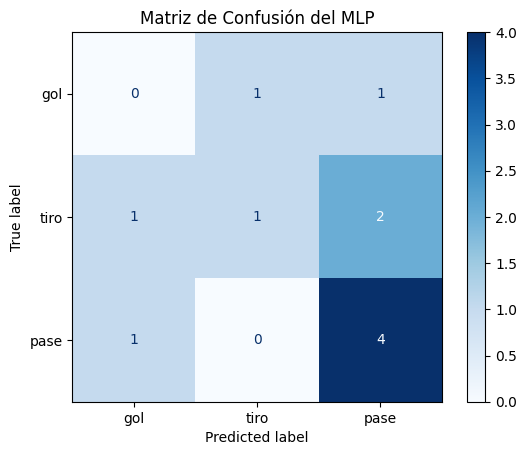

              precision    recall  f1-score   support

         gol       0.00      0.00      0.00         2
        tiro       0.50      0.25      0.33         4
        pase       0.57      0.80      0.67         5

    accuracy                           0.45        11
   macro avg       0.36      0.35      0.33        11
weighted avg       0.44      0.45      0.42        11



In [12]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Etiquetas reales y predichas
y_true = y_test_tensor.numpy()
y_pred = pred.numpy()
class_names = ['gol', 'tiro', 'pase']

# Matriz de confusión
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap="Blues")
plt.title("Matriz de Confusión del MLP")
plt.grid(False)
plt.show()

# Reporte de clasificación
print(classification_report(y_true, y_pred, target_names=class_names))


la matriz no es la mejor, vamos a profundizar mas


In [13]:
import os
import cv2
from pathlib import Path
from tqdm import tqdm

# Carpeta de entrada (videos) y salida (frames)
video_root = "/content/jugadas"
output_root = "/content/frames_jugadas_5frames"
os.makedirs(output_root, exist_ok=True)

# Iterar sobre las clases
for clase in os.listdir(video_root):
    clase_path = os.path.join(video_root, clase)
    output_class_dir = os.path.join(output_root, clase)
    os.makedirs(output_class_dir, exist_ok=True)

    # Iterar sobre los videos en cada clase
    for video_file in tqdm(os.listdir(clase_path), desc=f"Clase: {clase}"):
        video_path = os.path.join(clase_path, video_file)
        cap = cv2.VideoCapture(video_path)
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

        if total_frames < 5:
            step = 1
            frame_idxs = list(range(total_frames))  # Tomar todos los que haya
        else:
            step = total_frames // 5
            frame_idxs = [i * step for i in range(5)]

        for i, frame_idx in enumerate(frame_idxs):
            cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
            success, frame = cap.read()
            if success:
                frame_name = f"{Path(video_file).stem}_f{i}.jpg"
                cv2.imwrite(os.path.join(output_class_dir, frame_name), frame)
        cap.release()


Clase: gol: 100%|██████████| 8/8 [00:24<00:00,  3.05s/it]


In [14]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.io import read_image
from pathlib import Path
import numpy as np
from tqdm import tqdm

# 📂 Ruta base donde están los frames por clase
frames_path = Path("/content/frames_jugadas_5frames")

# 🧠 Modelo ResNet18 preentrenado
resnet = models.resnet18(pretrained=True)
resnet = torch.nn.Sequential(*list(resnet.children())[:-1])  # Quitar capa de clasificación
resnet.eval()

# 🔁 Transformaciones de entrada (igual a entrenamiento en ImageNet)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# 📥 Acumuladores
X = []
y = []
clases = sorted([p.name for p in frames_path.iterdir() if p.is_dir() and not p.name.startswith("__")])

# 🔄 Recorremos cada clase
for label, clase in enumerate(clases):
    imagenes = list((frames_path / clase).glob("*.jpg"))
    print(f"Clase: {clase}")
    for img_path in tqdm(imagenes):
        img = read_image(str(img_path)).float() / 255.0  # Cargar imagen como tensor
        img = transform(img).unsqueeze(0)  # Añadir batch
        with torch.no_grad():
            embedding = resnet(img).squeeze().numpy()
        X.append(embedding)
        y.append(label)

# Convertir a arrays finales
X = np.array(X)
y = np.array(y)

print("✅ Embeddings shape:", X.shape, "Labels shape:", y.shape)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Clase: gol


100%|██████████| 40/40 [00:08<00:00,  4.66it/s]


Clase: pase


100%|██████████| 110/110 [00:16<00:00,  6.83it/s]


Clase: tiro


100%|██████████| 110/110 [00:16<00:00,  6.63it/s]

✅ Embeddings shape: (260, 512) Labels shape: (260,)


🔁 Epoch 0, Loss: 1.1369
🔁 Epoch 10, Loss: 0.3022
🔁 Epoch 20, Loss: 0.1304
🔁 Epoch 30, Loss: 0.0471
🔁 Epoch 40, Loss: 0.0224
🔁 Epoch 49, Loss: 0.0153
✅ Reporte de clasificación:
              precision    recall  f1-score   support

         gol       0.75      0.75      0.75         8
        pase       0.84      0.95      0.89        22
        tiro       0.95      0.82      0.88        22

    accuracy                           0.87        52
   macro avg       0.85      0.84      0.84        52
weighted avg       0.87      0.87      0.86        52



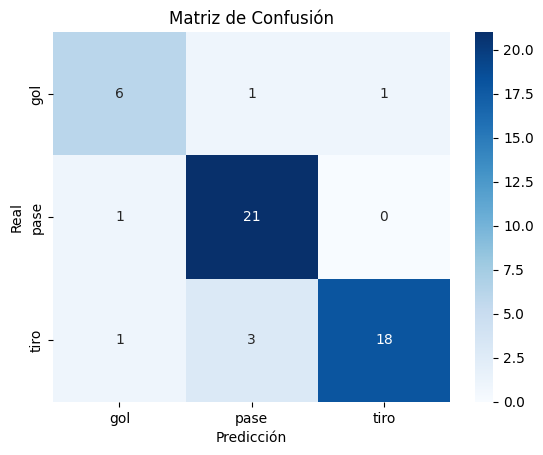

In [15]:
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import torch

# 📤 Dividir en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 🧼 Normalizar embeddings
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 🔁 Convertir a tensores
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# 🧠 Modelo MLP
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, output_dim)
        )
    def forward(self, x):
        return self.layers(x)

model = MLP(input_dim=512, hidden_dim=128, output_dim=3)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# 🔁 Entrenamiento
for epoch in range(50):
    model.train()
    optimizer.zero_grad()
    output = model(X_train_tensor)
    loss = criterion(output, y_train_tensor)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0 or epoch == 49:
        print(f"🔁 Epoch {epoch}, Loss: {loss.item():.4f}")

# ✅ Evaluación
model.eval()
with torch.no_grad():
    preds = model(X_test_tensor).argmax(dim=1)

print("✅ Reporte de clasificación:")
print(classification_report(y_test, preds, target_names=clases))

# 📊 Matriz de confusión
cm = confusion_matrix(y_test, preds)
sns.heatmap(cm, annot=True, fmt="d", xticklabels=clases, yticklabels=clases, cmap="Blues")
plt.title("Matriz de Confusión")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()


In [16]:
# 💾 Guardar modelo entrenado
torch.save(model.state_dict(), "mlp_resnet18.pt")


In [17]:
from google.colab import files
files.download("mlp_resnet18.pt")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

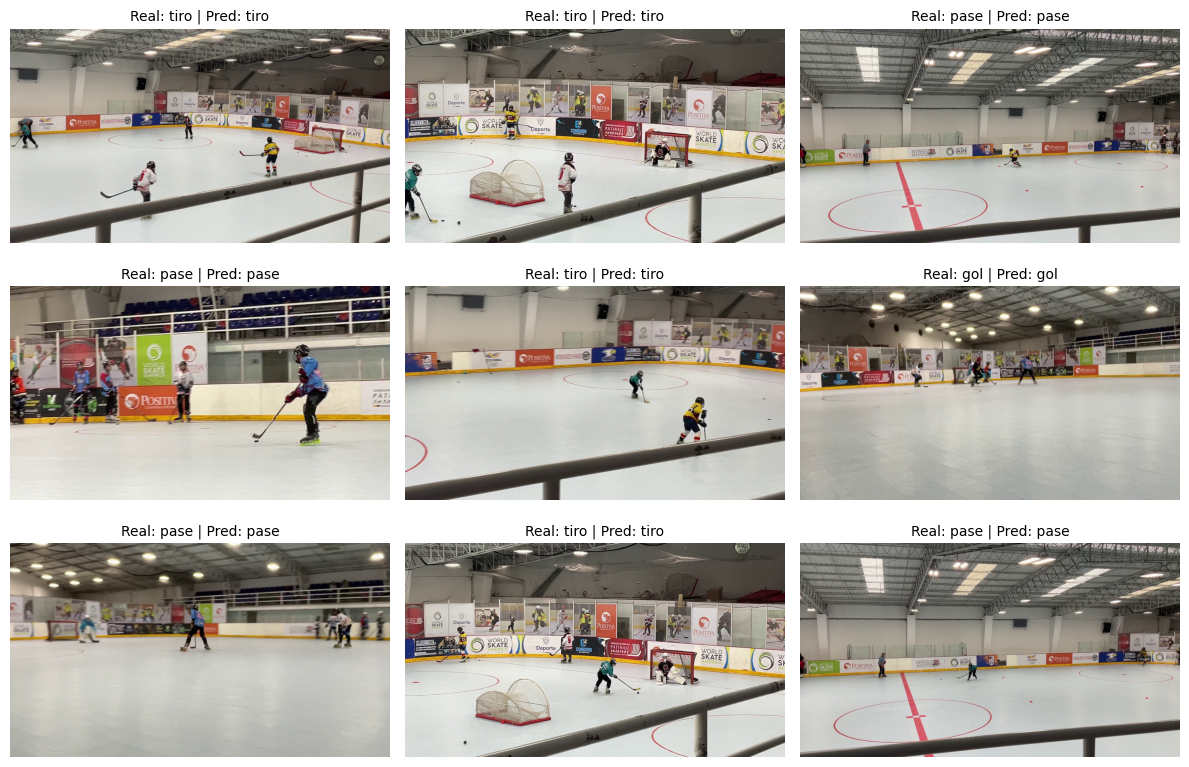

In [23]:
import os
import matplotlib.pyplot as plt
import random
import cv2
from pathlib import Path

# ✅ Ajusta según tu estructura real
frames_dir = "/content/frames_jugadas_5frames"
clases = ['gol', 'pase', 'tiro']

# 🔄 Reconstruir lista de paths en el mismo orden de X e y
paths_frames = []
labels = []

for clase_idx, clase in enumerate(clases):
    clase_path = os.path.join(frames_dir, clase)
    for fname in sorted(os.listdir(clase_path)):
        if fname.endswith((".jpg", ".png")):
            paths_frames.append(os.path.join(clase_path, fname))
            labels.append(clase_idx)

# ➗ Dividir como hicimos antes
from sklearn.model_selection import train_test_split
_, paths_test, _, y_test_recon = train_test_split(paths_frames, labels, test_size=0.2, stratify=labels, random_state=42)

# 🔮 Obtener predicciones sobre el test set
X_test_tensor = torch.tensor(scaler.transform(X_test), dtype=torch.float32)
preds = model(X_test_tensor).argmax(dim=1)

# 🎨 Mostrar aleatoriamente 9 frames del test set con su predicción
plt.figure(figsize=(12, 8))
sample_idxs = random.sample(range(len(paths_test)), 9)

for i, idx in enumerate(sample_idxs):
    img_path = paths_test[idx]
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    true_label = clases[y_test_recon[idx]]
    pred_label = clases[preds[idx]]

    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.title(f"Real: {true_label} | Pred: {pred_label}", fontsize=10)
    plt.axis("off")

plt.tight_layout()
plt.show()


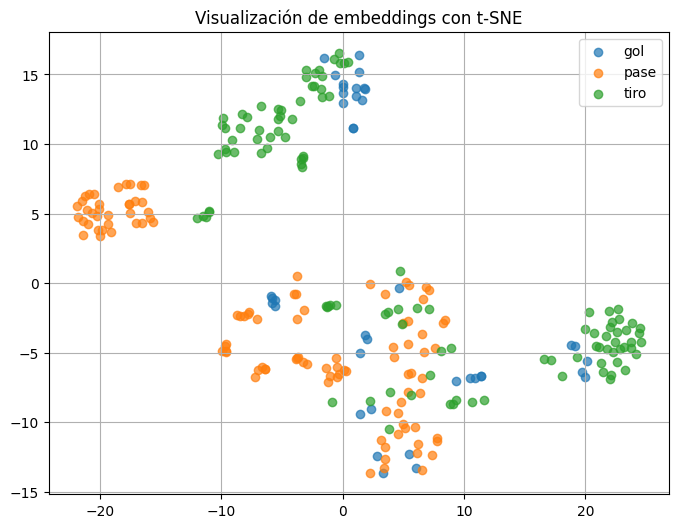

In [25]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X)

plt.figure(figsize=(8,6))
for i, clase in enumerate(clases):
    idxs = [j for j in range(len(y)) if y[j] == i]
    plt.scatter(X_tsne[idxs, 0], X_tsne[idxs, 1], label=clase, alpha=0.7)
plt.legend()
plt.title("Visualización de embeddings con t-SNE")
plt.grid(True)
plt.show()


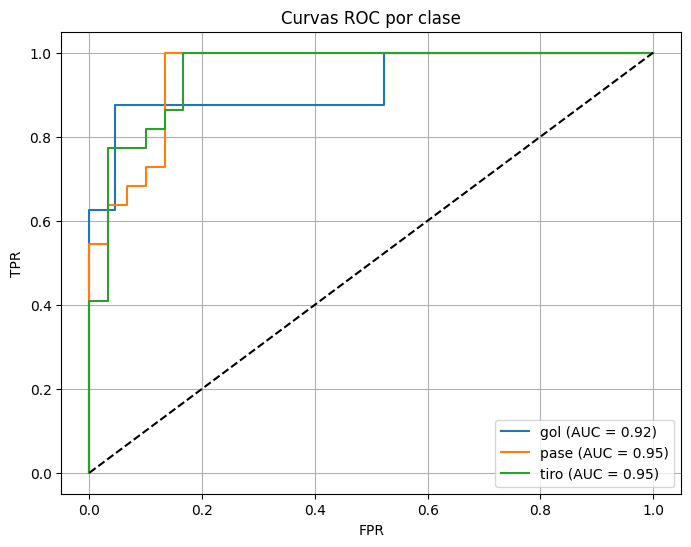

In [26]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
probs = model(X_test_tensor).detach().numpy()

plt.figure(figsize=(8,6))
for i, clase in enumerate(clases):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], probs[:, i])
    plt.plot(fpr, tpr, label=f"{clase} (AUC = {auc(fpr, tpr):.2f})")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("Curvas ROC por clase")
plt.legend()
plt.grid(True)
plt.show()


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


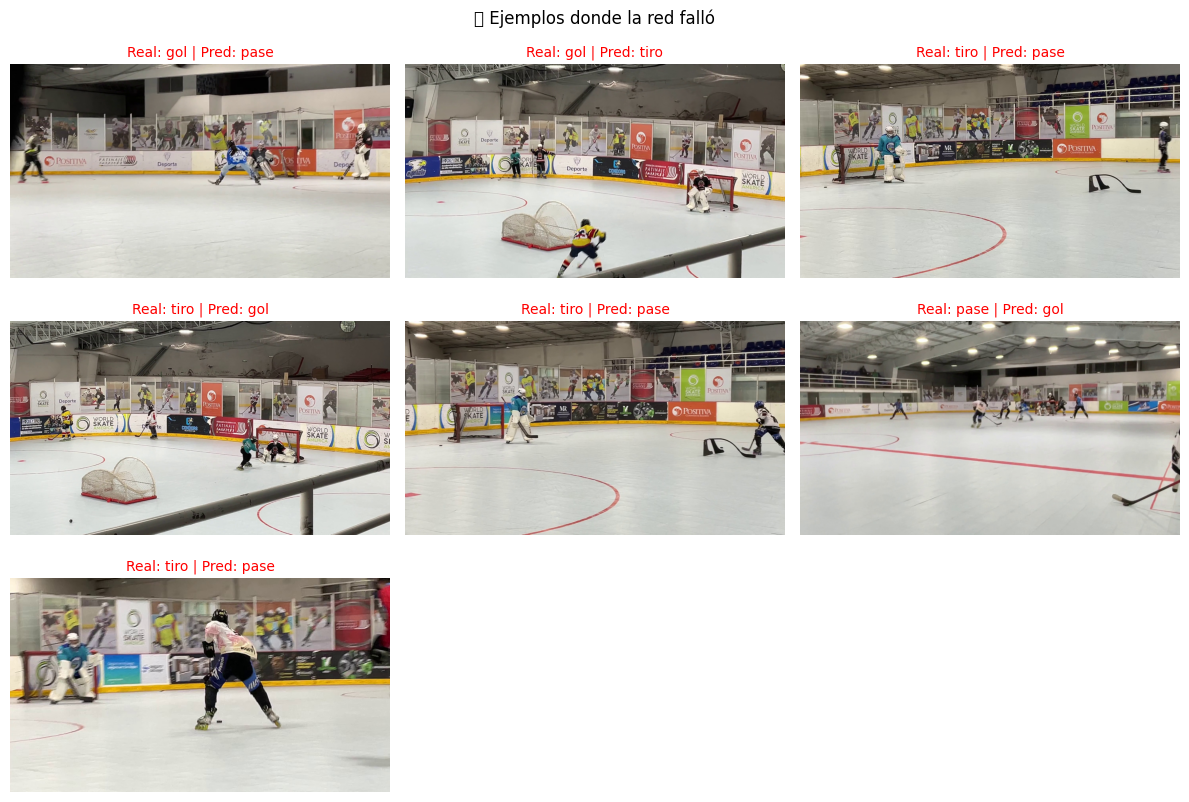

In [27]:
plt.figure(figsize=(12, 8))
errores = [i for i in range(len(y_test)) if preds[i] != y_test[i]]
errores = random.sample(errores, min(9, len(errores)))

for i, idx in enumerate(errores):
    img = cv2.imread(paths_test[idx])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    true_label = clases[y_test_recon[idx]]
    pred_label = clases[preds[idx]]

    plt.subplot(3, 3, i+1)
    plt.imshow(img)
    plt.title(f"Real: {true_label} | Pred: {pred_label}", fontsize=10, color='red')
    plt.axis("off")
plt.tight_layout()
plt.suptitle("❌ Ejemplos donde la red falló", y=1.02)
plt.show()


In [28]:
!pip install torchviz
!apt-get install graphviz -y


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 77.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 54.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 40.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [29]:
from torchviz import make_dot

# Usa un batch simulado para visualizar la red
dummy_input = torch.randn(1, 512)
output = model(dummy_input)

# Crea y muestra el grafo
make_dot(output, params=dict(model.named_parameters())).render("mlp_model", format="png")


'mlp_model.png'

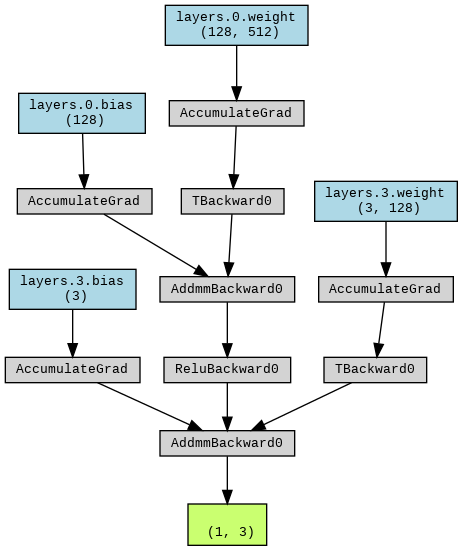

In [30]:
from IPython.display import Image
Image(filename="mlp_model.png")


In [31]:
!pip install torchsummary
from torchsummary import summary
summary(model, input_size=(512,))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]          65,664
              ReLU-2                  [-1, 128]               0
           Dropout-3                  [-1, 128]               0
            Linear-4                    [-1, 3]             387
Total params: 66,051
Trainable params: 66,051
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.25
Estimated Total Size (MB): 0.26
----------------------------------------------------------------
